# STAT 542 - Project 2 - Skin Cancer Diagnostics

### READ ME

* This .ipynb file is intended as a supplement to Part 1, corresponding to data processing and pixel-based classification


## Importing libraries:

In [41]:
from tqdm import tqdm

#Remove warnings:
import warnings
warnings.filterwarnings('ignore')

#Image reading and processing:
import cv2
import os
from sklearn.decomposition import FastICA, PCA

#Data preprocessing:
from sklearn.model_selection import train_test_split

#Classificaton:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#Accuracy metrics:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%pylab inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.image as mpimg
import seaborn
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Loading data:
The data is present in two different folders - one for benign and one for malignant images. The code below creates functions to load the images into two separate lists and also outputs a few images along with the number of nulls found in each list.

In [8]:
#Base folder:
repo = 'C:/Users/Pulkit Dixit/Desktop/STAT 542/Group Project/Data/542/'

#Function to load images:
def load_images(folder, grayscale = False):
    images = []
    cnt = 0
    for (idx, filename) in enumerate(os.listdir(folder)):
        if grayscale == True:
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(os.path.join(folder, filename))
            b,g,r = cv2.split(img)
            img = cv2.merge([r,g,b])
        
        #Adding image to list:
        if img is not None:
            images.append(img)
            
        #Count number of nulls:
        else:
            cnt = cnt + 1
        
        #Plot images:
        if idx%30 == 0:
            imgplot = plt.imshow(img)
            plt.show()
            
    print(str(len(images))+' images loaded. There were '+str(cnt)+' nulls found in the dataset.')
    return(images)

In [9]:
#Set flag for grayscale images:
grayscaleflag = False

Loading benign images and plotting a few sample images:


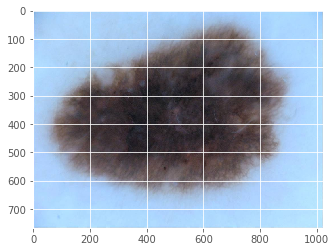

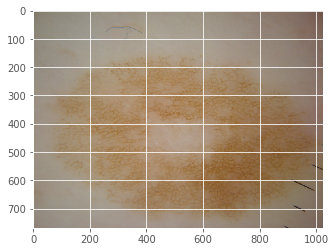

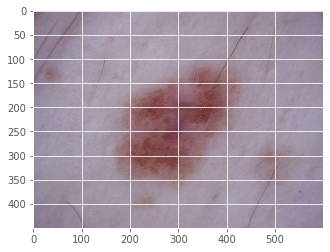

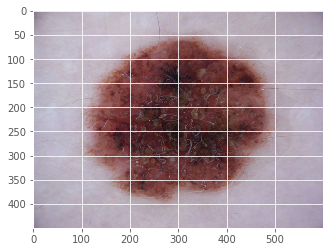

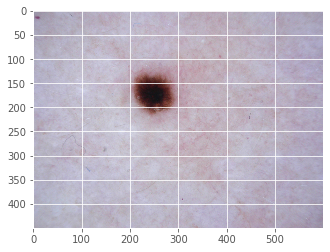

150 images loaded. There were 0 nulls found in the dataset.


In [10]:
#Benign images:
print('Loading benign images and plotting a few sample images:')
benign_images = load_images(repo+'benign/', grayscale = grayscaleflag)

Loading malignant images and plotting a few sample images:


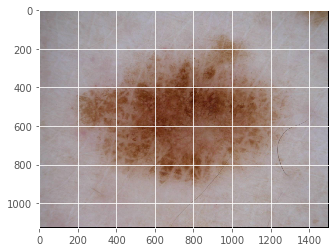

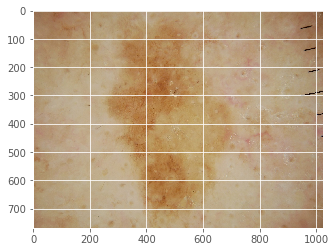

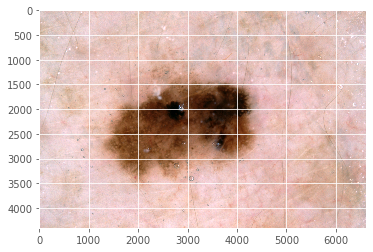

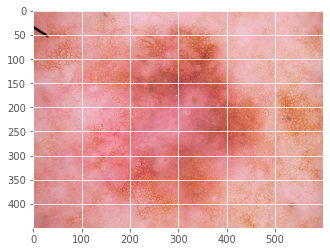

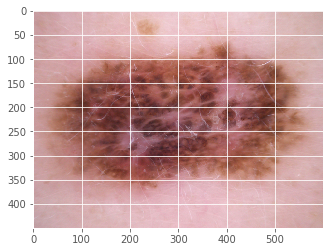

150 images loaded. There were 0 nulls found in the dataset.


In [11]:
#Malignant images:
print('Loading malignant images and plotting a few sample images:')
malignant_images = load_images(repo+'malignant/', grayscale = grayscaleflag)

Both folders have 150 images and no nulls. However, they seem to have different dimensions. They will need to be resized to a common dimension so that they can be flattened and inputted into the classification algorithms.

## Data Processing and Feature Engineering:
The following processing tasks would need to be performed on the images:
* Resizing - the images are of different dimensions and need to be resized to a common set of dimensions.
* Flattening - the images have 3 channels each, and need to be flattened into 1D vectors so that they can be used for feature reduction and classification.
* Normalizing - each pixel of every image is a value in the range 0-255. They need to normalized so that none of paarameters of the classification algorithms explode due to very high values.

In [12]:
def resize_images(images, dim):
    return list(map(lambda x: cv2.resize(x, dsize = dim, interpolation = cv2.INTER_CUBIC), images))

def flatten_images(images, h, w, channels, grayscale = False):
    if grayscale == True:
        return list(map(lambda x: x.reshape(h*w), images)) #for grayscale
    else:
        return list(map(lambda x: x.reshape(h*w*channels), images)) #for non-grayscale

def normalize_images(images):
    return list(map(lambda x: cv2.normalize(x, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).flatten('F'), images))

In [13]:
'''
Function for pre-processing both benign and malignant images. The following operations are performed:
1. Re-size to a common image size.
2. Flatten images into a vector.
3. Normalize images.
'''

def preprocess_images(images, h, w, grayscale = False):
    gsflag = grayscale
    channels = 3
    resized = resize_images(images, (h, w))
    flattened = flatten_images(resized, h, w, channels, grayscale = gsflag)
    normalized = normalize_images(flattened)
    return(np.array(normalized))

benign_processed = preprocess_images(benign_images, h = 256, w = 256, grayscale = grayscaleflag)
malignant_processed = preprocess_images(malignant_images, h = 256, w = 256, grayscale = grayscaleflag)

The pre-processed images contain noise as well. This could be in the presence of body hair, dirt on the camera lense, dirt on the body, etc. Here, it is assumed that the dirt/noise is darker in color than the body, which is also the background color. Hence, the images are dilated to remove black noise. The code below cleans the images and outputs a list of flattened arrays. 

In [14]:
'''
Function to remove noise and hair from the images by using binary morphology and dilation.
'''
def denoise_images(images):
    kernel = np.ones((5,5),np.uint8)
    opening = list(map(lambda x: cv2.morphologyEx(x, cv2.MORPH_OPEN, kernel, iterations=2), images))
    dilate = list(map(lambda x: cv2.dilate(x, kernel,iterations = 2).flatten('F'), opening))
    return(dilate)

benign_denoised = np.array(denoise_images(benign_processed))
malignant_denoised = np.array(denoise_images(malignant_processed))

A comparison of a randomly selected image and its denoised version are shown below:

With noise:


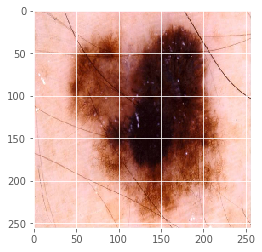

Without noise:


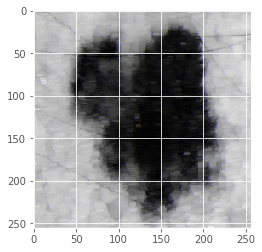

In [64]:
#Plot image with noise
print('With noise:')
img = malignant_processed[4].reshape(256,256,3)
plt.imshow(img)
plt.show()

#Plot image without noise
print('Without noise:')
img = malignant_denoised[4].reshape(256,256,3)
plt.imshow(img)
plt.show()

It can be observed that the effect of the nearby hair is reduced in the denoised image as compared to the original image.

Next, labels need to be created for both classes of images (Benign = 0, Malignant = 1)

In [15]:
benign_label = np.zeros(benign_denoised.shape[0])
malignant_label = np.ones(malignant_denoised.shape[0])

The two classes of images and labels are present in separate variables and need to be concatenated so that they can be randomly split into train and test sets.

In [16]:
#labels
y = np.concatenate((benign_label, malignant_label), axis=0)

#data
X = np.concatenate((benign_denoised, malignant_denoised), axis=0)

Splitting into train and test sets:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)

print('Shape of train set: ', X_train.shape)
print('Shape of test set: ', X_test.shape)

Shape of train set:  (210, 196608)
Shape of test set:  (90, 196608)


## Dimension Reduction:
It can be noticed that the number of variables is a lot more than the number of data observations. Thus, feature reduction needs to be performed on the images. This can be done via Independent Component Analysis (ICA), which transforms data into independent explainable features or Principal Component Analysis (PCA), which transforms the data into elements that explain as much variance in the data as possible. The code below performs Independent Component Analysis (ICA) or Principal Component Analysis (PCA) on the data:

In [18]:
'''
This function uses method to input PCA or ICA, and num_comp to input 
the number of dimensions that need to be present in the new data set.
'''
def dimension_reduction(method, num_comp):
    if method == 'ICA':
        #ICA
        ica = FastICA(n_components = num_comp, whiten = True)
        X_train_reduced = ica.fit_transform(X_train)
        X_test_reduced = ica.transform(X_test)
    elif method == 'PCA':
        #PCA
        pca = PCA(n_components = num_comp)
        X_train_reduced = pca.fit_transform(X_train)
        X_test_reduced = pca.transform(X_test)
    else:
        print('Neither ICA nor PCA specified. Ending function execution.')
        return
    
    #Print shape of resulting data sets:
    print('Shape of feature-reduced train set: ', X_train_reduced.shape)
    print('Shape of feature-reduced test set: ', X_test_reduced.shape)
    
    return(X_train_reduced, X_test_reduced)

## Classification:
Next, the reduced train data needs to be fit into classification algorithms and the test data needs to be used to predict whether an image in the test set represents benign or malignant cancer. For this purpose, both linear and non-linear algorithms are used in order to understand whether or not the 2 classes have a linear or non-linear boundary. The code below creates a function that uses the train and test data to perform classification:

In [39]:
'''
This function takes the train and test data to run classification algorithms to 
predict labels for the test sets.
Valid values for method are 'Naive Bayes', 'Logistic Regression', 'LDA', 'Linear SVM',
'KNN' and 'Radial SVM'.
'''
def classification(method, X_train_reduced, X_test_reduced, y_train, y_test, classes, neighbors = False):
    #Initialize algorithm:
    if method == 'Naive Bayes':
        model = GaussianNB()
        
    elif method == 'Logistic Regression':
        model = LogisticRegression(random_state=0)
        
    elif method == 'LDA':
        model = LinearDiscriminantAnalysis()
        
    elif method == 'Linear SVM':
        model = LinearSVC(random_state=0, tol=1e-3)
        
    elif method == 'Radial SVM':
        model = rsvm = SVC(gamma='auto', kernel = 'rbf')
        
    elif method == 'KNN':
        model = KNeighborsClassifier(n_neighbors= neighbors)
        
    else:
        print('Invalid algorithm entered. Ending function execution.')
        return
    
    #Fit train data and get test predictions:
    y_pred = model.fit(X_train_reduced, y_train).predict(X_test_reduced)
    print('Model selected: ', method)
    print('Classification Report: \n', classification_report(y_test, y_pred, target_names = classes))
    cm =  confusion_matrix(y_test, y_pred)
    print('Confusion matrix: \n', pd.DataFrame(cm, columns=classes, index=classes))
    
    return

The data will first be fit using algorithms that create linear boundaries for classification. If they do not perform well, a non-linear method will be tried as well.

### Logistic Regression:

Using ICA:

In [31]:
#Obtain reduced dataset:
X_train_reduced, X_test_reduced = dimension_reduction('ICA', num_comp = 3)

#Logistic Regression:
lab = ['Benign', 'Malignant']
classification('Logistic Regression', X_train_reduced, X_test_reduced, y_train, y_test, classes = lab)

Shape of feature-reduced train set:  (210, 3)
Shape of feature-reduced test set:  (90, 3)
Model selected:  Logistic Regression
Classification Report: 
               precision    recall  f1-score   support

      Benign       0.52      0.70      0.59        43
   Malignant       0.59      0.40      0.48        47

    accuracy                           0.54        90
   macro avg       0.56      0.55      0.54        90
weighted avg       0.56      0.54      0.54        90

Confusion matrix: 
            Benign  Malignant
Benign         30         13
Malignant      28         19


Using PCA:

In [32]:
#Obtain reduced dataset:
X_train_reduced, X_test_reduced = dimension_reduction('PCA', num_comp = 3)

#Logistic Regression:
lab = ['Benign', 'Malignant']
classification('Logistic Regression', X_train_reduced, X_test_reduced, y_train, y_test, classes = lab)

Shape of feature-reduced train set:  (210, 3)
Shape of feature-reduced test set:  (90, 3)
Model selected:  Logistic Regression
Classification Report: 
               precision    recall  f1-score   support

      Benign       0.54      0.70      0.61        43
   Malignant       0.62      0.45      0.52        47

    accuracy                           0.57        90
   macro avg       0.58      0.57      0.56        90
weighted avg       0.58      0.57      0.56        90

Confusion matrix: 
            Benign  Malignant
Benign         30         13
Malignant      26         21


PCA performs better than ICA by classifying two more malignant tumors correctly.

### Linear Discriminant Analysis: 
Using ICA:

In [33]:
#Obtain reduced dataset:
X_train_reduced, X_test_reduced = dimension_reduction('ICA', num_comp = 3)

#LDA:
lab = ['Benign', 'Malignant']
classification('LDA', X_train_reduced, X_test_reduced, y_train, y_test, classes = lab)

Shape of feature-reduced train set:  (210, 3)
Shape of feature-reduced test set:  (90, 3)
Model selected:  LDA
Classification Report: 
               precision    recall  f1-score   support

      Benign       0.54      0.70      0.61        43
   Malignant       0.62      0.45      0.52        47

    accuracy                           0.57        90
   macro avg       0.58      0.57      0.56        90
weighted avg       0.58      0.57      0.56        90

Confusion matrix: 
            Benign  Malignant
Benign         30         13
Malignant      26         21


Using PCA:

In [34]:
#Obtain reduced dataset:
X_train_reduced, X_test_reduced = dimension_reduction('PCA', num_comp = 3)

#LDA:
lab = ['Benign', 'Malignant']
classification('LDA', X_train_reduced, X_test_reduced, y_train, y_test, classes = lab)

Shape of feature-reduced train set:  (210, 3)
Shape of feature-reduced test set:  (90, 3)
Model selected:  LDA
Classification Report: 
               precision    recall  f1-score   support

      Benign       0.54      0.70      0.61        43
   Malignant       0.62      0.45      0.52        47

    accuracy                           0.57        90
   macro avg       0.58      0.57      0.56        90
weighted avg       0.58      0.57      0.56        90

Confusion matrix: 
            Benign  Malignant
Benign         30         13
Malignant      26         21


So, LDA performs equally well using both PCA and ICA.

### Linear SVM:
Using ICA:

In [35]:
#Obtain reduced dataset:
X_train_reduced, X_test_reduced = dimension_reduction('ICA', num_comp = 3)

#Linear SVM:
lab = ['Benign', 'Malignant']
classification('Linear SVM', X_train_reduced, X_test_reduced, y_train, y_test, classes = lab)

Shape of feature-reduced train set:  (210, 3)
Shape of feature-reduced test set:  (90, 3)
Model selected:  Linear SVM
Classification Report: 
               precision    recall  f1-score   support

      Benign       0.54      0.70      0.61        43
   Malignant       0.62      0.45      0.52        47

    accuracy                           0.57        90
   macro avg       0.58      0.57      0.56        90
weighted avg       0.58      0.57      0.56        90

Confusion matrix: 
            Benign  Malignant
Benign         30         13
Malignant      26         21


Using PCA:

In [36]:
#Obtain reduced dataset:
X_train_reduced, X_test_reduced = dimension_reduction('PCA', num_comp = 3)

#Linear SVM:
lab = ['Benign', 'Malignant']
classification('Linear SVM', X_train_reduced, X_test_reduced, y_train, y_test, classes = lab)

Shape of feature-reduced train set:  (210, 3)
Shape of feature-reduced test set:  (90, 3)
Model selected:  Linear SVM
Classification Report: 
               precision    recall  f1-score   support

      Benign       0.56      0.67      0.61        43
   Malignant       0.63      0.51      0.56        47

    accuracy                           0.59        90
   macro avg       0.59      0.59      0.59        90
weighted avg       0.60      0.59      0.59        90

Confusion matrix: 
            Benign  Malignant
Benign         29         14
Malignant      23         24


The Linear SVM performs better on PCA than on ICA, and does better that the previous two models in terms of accuracy.

Since models creating linear boundaries don't get more than 60% accuracy, it might be better to try non-linear models instead.

### Naive Bayes:
Using ICA:

In [37]:
#Obtain reduced dataset:
X_train_reduced, X_test_reduced = dimension_reduction('ICA', num_comp = 3)

#Naive Bayes:
lab = ['Benign', 'Malignant']
classification('Naive Bayes', X_train_reduced, X_test_reduced, y_train, y_test, classes = lab)

Shape of feature-reduced train set:  (210, 3)
Shape of feature-reduced test set:  (90, 3)
Model selected:  Naive Bayes
Classification Report: 
               precision    recall  f1-score   support

      Benign       0.53      0.72      0.61        43
   Malignant       0.62      0.43      0.51        47

    accuracy                           0.57        90
   macro avg       0.58      0.57      0.56        90
weighted avg       0.58      0.57      0.56        90

Confusion matrix: 
            Benign  Malignant
Benign         31         12
Malignant      27         20


Using PCA:

In [38]:
#Obtain reduced dataset:
X_train_reduced, X_test_reduced = dimension_reduction('PCA', num_comp = 3)

#Naive Bayes:
lab = ['Benign', 'Malignant']
classification('Naive Bayes', X_train_reduced, X_test_reduced, y_train, y_test, classes = lab)

Shape of feature-reduced train set:  (210, 3)
Shape of feature-reduced test set:  (90, 3)
Model selected:  Naive Bayes
Classification Report: 
               precision    recall  f1-score   support

      Benign       0.52      0.72      0.60        43
   Malignant       0.60      0.38      0.47        47

    accuracy                           0.54        90
   macro avg       0.56      0.55      0.53        90
weighted avg       0.56      0.54      0.53        90

Confusion matrix: 
            Benign  Malignant
Benign         31         12
Malignant      29         18


Naive Bayes performs better using ICA than using PCA. It also classifies more correct benign cases than any previous model.

### K-Nearest Neighbors:
Using ICA:

In [47]:
#Obtain reduced dataset:
X_train_reduced, X_test_reduced = dimension_reduction('ICA', num_comp = 3)

#KNN:
lab = ['Benign', 'Malignant']
classification('KNN', X_train_reduced, X_test_reduced, y_train, y_test, classes = lab, neighbors = 3)

Shape of feature-reduced train set:  (210, 3)
Shape of feature-reduced test set:  (90, 3)
Model selected:  KNN
Classification Report: 
               precision    recall  f1-score   support

      Benign       0.56      0.70      0.62        43
   Malignant       0.64      0.49      0.55        47

    accuracy                           0.59        90
   macro avg       0.60      0.59      0.59        90
weighted avg       0.60      0.59      0.58        90

Confusion matrix: 
            Benign  Malignant
Benign         30         13
Malignant      24         23


Using PCA:

In [49]:
#Obtain reduced dataset:
X_train_reduced, X_test_reduced = dimension_reduction('PCA', num_comp = 3)

#KNN:
lab = ['Benign', 'Malignant']
classification('KNN', X_train_reduced, X_test_reduced, y_train, y_test, classes = lab, neighbors = 7)

Shape of feature-reduced train set:  (210, 3)
Shape of feature-reduced test set:  (90, 3)
Model selected:  KNN
Classification Report: 
               precision    recall  f1-score   support

      Benign       0.55      0.63      0.59        43
   Malignant       0.61      0.53      0.57        47

    accuracy                           0.58        90
   macro avg       0.58      0.58      0.58        90
weighted avg       0.58      0.58      0.58        90

Confusion matrix: 
            Benign  Malignant
Benign         27         16
Malignant      22         25


With 7 neighbors, KNN classifies a large number of malignant images correctly.

### Radial SVM:
Using ICA:

In [50]:
#Obtain reduced dataset:
X_train_reduced, X_test_reduced = dimension_reduction('ICA', num_comp = 3)

#Radial SVM:
lab = ['Benign', 'Malignant']
classification('Radial SVM', X_train_reduced, X_test_reduced, y_train, y_test, classes = lab, neighbors = 3)

Shape of feature-reduced train set:  (210, 3)
Shape of feature-reduced test set:  (90, 3)
Model selected:  Radial SVM
Classification Report: 
               precision    recall  f1-score   support

      Benign       0.48      1.00      0.65        43
   Malignant       0.00      0.00      0.00        47

    accuracy                           0.48        90
   macro avg       0.24      0.50      0.32        90
weighted avg       0.23      0.48      0.31        90

Confusion matrix: 
            Benign  Malignant
Benign         43          0
Malignant      47          0


Using PCA:

In [51]:
#Obtain reduced dataset:
X_train_reduced, X_test_reduced = dimension_reduction('PCA', num_comp = 3)

#Radial SVM:
lab = ['Benign', 'Malignant']
classification('Radial SVM', X_train_reduced, X_test_reduced, y_train, y_test, classes = lab, neighbors = 3)

Shape of feature-reduced train set:  (210, 3)
Shape of feature-reduced test set:  (90, 3)
Model selected:  Radial SVM
Classification Report: 
               precision    recall  f1-score   support

      Benign       0.48      1.00      0.65        43
   Malignant       0.00      0.00      0.00        47

    accuracy                           0.48        90
   macro avg       0.24      0.50      0.32        90
weighted avg       0.23      0.48      0.31        90

Confusion matrix: 
            Benign  Malignant
Benign         43          0
Malignant      47          0


The Radial SVM is the worst performing model since it did not identify any image as malignant.

Since both linear and non-linear models failed to attain good accuracy measures, reducing the images to just two dimensions and plotting the train set could explain why this is happening.

Shape of feature-reduced train set:  (210, 2)
Shape of feature-reduced test set:  (90, 2)
ICA Components:


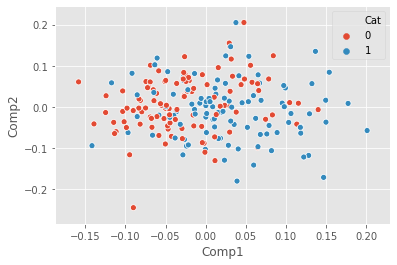

In [57]:
X_train_reduced, X_test_reduced = dimension_reduction('ICA', num_comp = 2)

#Plot the components and color labels.
print('ICA Components:')
cat = [0,1]
df = pd.DataFrame({
    'Comp1': X_train_reduced[:,0],
    'Comp2': X_train_reduced[:,1],
    'Cat': y_train
})

fg = seaborn.scatterplot(x = df['Comp1'], y = df['Comp2'], hue=df['Cat'], hue_order=cat)

Shape of feature-reduced train set:  (210, 2)
Shape of feature-reduced test set:  (90, 2)
PCA Components:


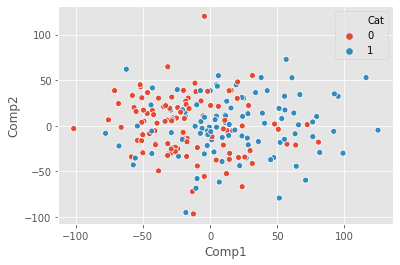

In [58]:
X_train_reduced, X_test_reduced = dimension_reduction('PCA', num_comp = 2)

#Plot the components and color labels.
print('PCA Components:')
cat = [0,1]
df = pd.DataFrame({
    'Comp1': X_train_reduced[:,0],
    'Comp2': X_train_reduced[:,1],
    'Cat': y_train
})

fg = seaborn.scatterplot(x = df['Comp1'], y = df['Comp2'], hue=df['Cat'], hue_order=cat)

Both scatterplots show that there is no distinct decision boundary - linear or non-linear - between the two classes of images. This is why none of the models attain accuracies over 60%. This shows that classifying skin cancer images based on pixel values is not an appropriate way to proceed with the classifying problem. Intuitively, this makes sense since the images contain skin, moles and sometimes hairs, all of which are extremely similar in color. This would make pixel-based classification hard, especially for a dataset of only 300 images as the classification algorithms would not be able to learn the differences between the two images. As an alternate solution feature extraction (intensity, color gradient, edge detection, etc.) could be performed on the images and used for classification instead.